# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import gc
import datetime
import os

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask, random_mask_rectangle, random_mask_line_for_ct

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
# TRAIN_DIR = r"/mnt/data/huojiayu/small_xray_v2/train/"
TEST_DIR = r"/mnt/data/huojiayu/testset_xray/"
# VAL_DIR = r"/mnt/data/huojiayu/small_xray_v2/val/"

TRAIN_DIR = r"/mnt/data/huojiayu/liver_image/train/"
VAL_DIR = r"/mnt/data/huojiayu/liver_image/val/"

BATCH_SIZE = 4

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


# Creating train & test data generator

In [5]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
#             mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            mask = np.stack([random_mask_line_for_ct(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)  

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(
    rescale=1./255,
#     rotation_range=3,
#     width_shift_range=0.03,
#     height_shift_range=0.03,
    horizontal_flip=True,
    fill_mode = "constant",
    cval = 0
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(512, 512), batch_size=BATCH_SIZE,
)

# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(512, 512), batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(512, 512), batch_size=1, seed=1, shuffle=False,
)

In [ ]:
# Pick out an example
# train_data = next(train_generator)
# (masked, mask), ori = train_data

data_a_path = '/mnt/data/huojiayu/PConv-Keras/test_image/A/'
data_b_path = '/mnt/data/huojiayu/PConv-Keras/test_image/B/'

# Show side by side
for i in range(1000):
    train_data = next(train_generator)
    (masked, mask), ori = train_data
    
    masked = np.squeeze(masked)
    ori = np.squeeze(ori)

    # print(type(masked), type(ori))
    print(str(i+1))

    # cv2.imwrite(data_a_path + 'raw_' + str(i + 1) + '.png', ori)
    # cv2.imwrite(data_b_path + 'gen_' + str(i + 1) + '.png', masked)

    matplotlib.image.imsave(data_a_path + str(i + 1) + '_A' + '.png', ori)
    matplotlib.image.imsave(data_b_path + str(i + 1) + '_B' + '.png', masked)

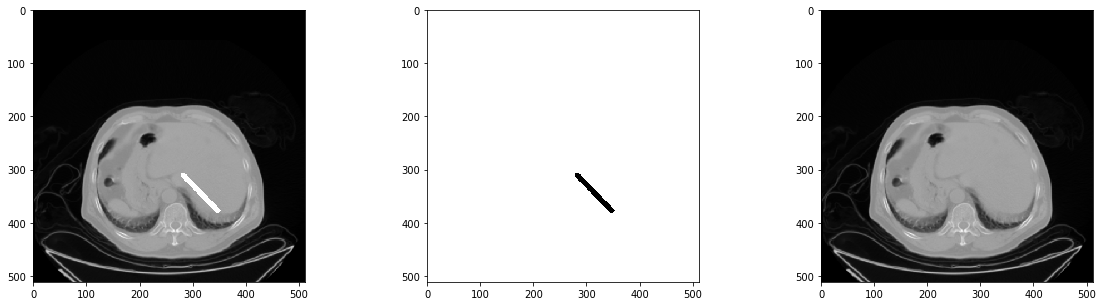

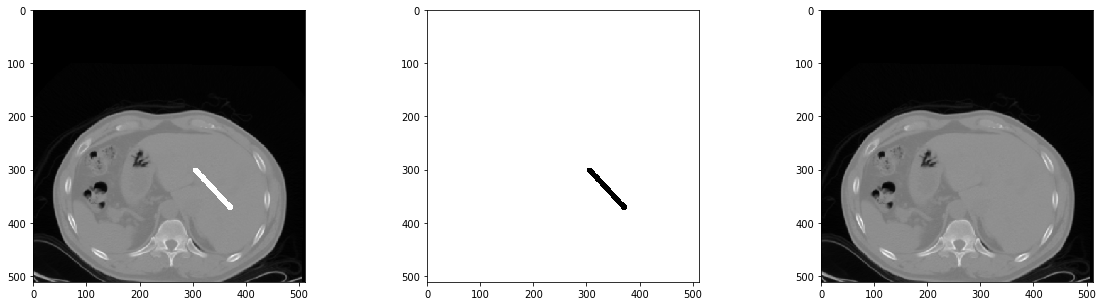

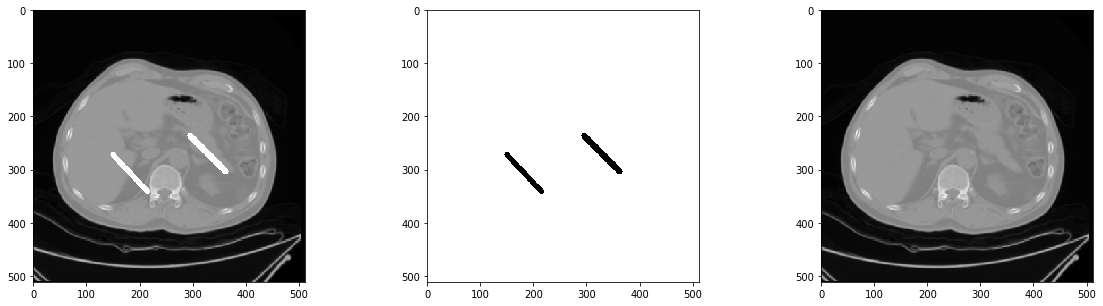

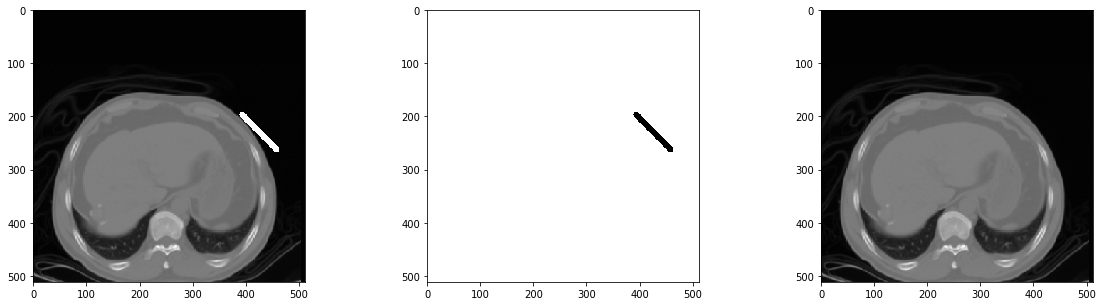

In [7]:
# Pick out an example
train_data = next(train_generator)
(masked, mask), ori = train_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [8]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples_ct/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [9]:
# Instantiate the model
model = PConvUnet(weight_filepath='data/logs_ct/')
# model.load(r"data/logs_ct/20_weights_2018-11-23-17-38-32.h5")

In [10]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=500,
    validation_data=val_generator,
    validation_steps=100,
    epochs=100,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='./data/logs_ct/initial_training', write_graph=False)
    ]
)

Epoch 1/1
Found 60 images belonging to 1 classes.
500/500 [==============================] - 555s 1s/step - loss: 434294.1993 - val_loss: 296704.4728
Epoch 2/2
500/500 [==============================] - 542s 1s/step - loss: 167936.3604 - val_loss: 99815.1560
Epoch 3/3
500/500 [==============================] - 542s 1s/step - loss: 84055.0504 - val_loss: 74350.9383
Epoch 4/4
500/500 [==============================] - 542s 1s/step - loss: 65683.9542 - val_loss: 58041.1696
Epoch 5/5
500/500 [==============================] - 541s 1s/step - loss: 58489.0152 - val_loss: 60804.6069
Epoch 6/6
500/500 [==============================] - 541s 1s/step - loss: 53051.4113 - val_loss: 53658.7457
Epoch 7/7
500/500 [==============================] - 541s 1s/step - loss: 52007.7118 - val_loss: 51696.8092
Epoch 8/8
500/500 [==============================] - 542s 1s/step - loss: 47542.2360 - val_loss: 44031.3706
Epoch 9/9
500/500 [==============================] - 542s 1s/step - loss: 45987.6789 - val_lo

500/500 [==============================] - 640s 1s/step - loss: 16758.6837 - val_loss: 20264.6975
Epoch 76/76
500/500 [==============================] - 644s 1s/step - loss: 16498.4401 - val_loss: 18443.9190
Epoch 77/77
500/500 [==============================] - 653s 1s/step - loss: 16424.2063 - val_loss: 18326.3954
Epoch 78/78
500/500 [==============================] - 667s 1s/step - loss: 16471.0961 - val_loss: 20421.8898
Epoch 79/79
500/500 [==============================] - 676s 1s/step - loss: 16480.4332 - val_loss: 17789.3543
Epoch 80/80
500/500 [==============================] - 685s 1s/step - loss: 16180.6593 - val_loss: 18364.6901
Epoch 81/81
500/500 [==============================] - 690s 1s/step - loss: 16285.8433 - val_loss: 20326.6669
Epoch 82/82
500/500 [==============================] - 685s 1s/step - loss: 16214.7317 - val_loss: 16601.9726
Epoch 83/83
500/500 [==============================] - 702s 1s/step - loss: 16059.3199 - val_loss: 18642.0907
Epoch 84/84
500/500 [=

/home/huojiayu/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.101948). Check your callbacks.
  % delta_t_median)


500/500 [==============================] - 722s 1s/step - loss: 15251.5248 - val_loss: 16812.5963
Epoch 88/88
500/500 [==============================] - 738s 1s/step - loss: 15531.0692 - val_loss: 19594.8735
Epoch 89/89
500/500 [==============================] - 741s 1s/step - loss: 15669.9773 - val_loss: 16407.4155
Epoch 90/90
500/500 [==============================] - 761s 2s/step - loss: 15289.6252 - val_loss: 21252.9804
Epoch 91/91
500/500 [==============================] - 753s 2s/step - loss: 15230.8929 - val_loss: 19708.6121
Epoch 92/92
500/500 [==============================] - 763s 2s/step - loss: 14839.6599 - val_loss: 16300.2859
Epoch 93/93
500/500 [==============================] - 773s 2s/step - loss: 14913.3554 - val_loss: 16318.6160
Epoch 94/94
500/500 [==============================] - 758s 2s/step - loss: 15019.5371 - val_loss: 16741.0802
Epoch 95/95
500/500 [==============================] - 753s 2s/step - loss: 15023.7819 - val_loss: 16812.6460
Epoch 96/96
500/500 [=

## Phase 2 - without batch normalization

In [ ]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    r"C:\Users\MAFG\Documents\Github-Public\PConv-Keras\data\logs\150_weights_2018-06-26-22-19-32.h5",
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=,
    validation_data=val_generator,
    validation_steps=100,
    epochs=20,        
    workers=3,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='../data/logs/fine_tuning', write_graph=False)
    ]
)

## Phase 3 - Generating samples

In [ ]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    r"data/logs/25_weights_2018-11-19-15-57-00.h5",
    train_bn=False,
    lr=0.00005
)

In [16]:
n = 0
# !rm -rf /mnt/data/huojiayu/PConv-Keras/data/test_samples/masked/xray/*
# !rm -rf /mnt/data/huojiayu/PConv-Keras/data/test_samples/mask/xray/*
# !rm -rf /mnt/data/huojiayu/PConv-Keras/data/test_samples/pred/xray/*
# !rm -rf /mnt/data/huojiayu/PConv-Keras/data/test_samples/ori/xray/*

masked_path = '/mnt/data/huojiayu/PConv-Keras/data/test_samples/masked/xray/'
mask_path = '/mnt/data/huojiayu/PConv-Keras/data/test_samples/mask/xray/'
pred_path = '/mnt/data/huojiayu/PConv-Keras/data/test_samples/pred/xray/'
ori_path = '/mnt/data/huojiayu/PConv-Keras/data/test_samples/ori/xray/'
# data_b_path = '/mnt/data/huojiayu/PConv-Keras/test_image/B/'

for (masked, mask), ori in tqdm(test_generator):
# for (masked, mask), ori in test_generator:
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
#     # Clear current output and display test images
#     for i in range(len(ori)):
#         _, axes = plt.subplots(1, 2, figsize=(10, 5))
#         axes[0].imshow(masked[i,:,:,:])
#         axes[0].axis('off')
#         axes[1].imshow(pred_img[i,:,:,:] * 1.)
#         axes[1].axis('off')
#         axes[0].set_title('Masked Image')
#         axes[1].set_title('Predicted Image')
#         axes[0].xaxis.set_major_formatter(NullFormatter())
#         axes[0].yaxis.set_major_formatter(NullFormatter())
#         axes[1].xaxis.set_major_formatter(NullFormatter())
#         axes[1].yaxis.set_major_formatter(NullFormatter())
        
#         plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
#         plt.close()
#         n += 1
    print(mask.shape)
    print(masked.shape)
    print(ori.shape)
    print(pred_img.shape)
    masked = np.squeeze(masked)
    mask = np.squeeze(mask)
    mask = mask * 1.
    pred_img = np.squeeze(pred_img)
    ori = np.squeeze(ori)

#     # print(type(masked), type(ori))
# #     print(str(i+1))

#     # cv2.imwrite(data_a_path + 'raw_' + str(i + 1) + '.png', ori)
#     # cv2.imwrite(data_b_path + 'gen_' + str(i + 1) + '.png', masked)

#     matplotlib.image.imsave(masked_path + str(n + 1) + '_B' + '.png', masked)
#     matplotlib.image.imsave(pred_path + str(n + 1) + '_pred' + '.png', pred_img)
#     matplotlib.image.imsave(ori_path + str(n + 1) + '_A' + '.png', ori)
#     matplotlib.image.imsave(mask_path + str(n + 1) + '_mask' + '.png', mask)
    
#     n += 1
        
#     # Only create predictions for about 1000 images
#     if n > 499:
#         break

0it [00:00, ?it/s]

Found 500 images belonging to 1 classes.


1it [00:03,  4.00s/it]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


2it [00:04,  2.89s/it]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


3it [00:04,  2.11s/it]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


4it [00:04,  1.58s/it]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


5it [00:05,  1.20s/it]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


6it [00:05,  1.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


7it [00:05,  1.34it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


8it [00:06,  1.61it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


9it [00:06,  1.80it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


10it [00:06,  2.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


11it [00:07,  2.35it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


12it [00:07,  2.52it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


13it [00:07,  2.66it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


14it [00:08,  2.90it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


15it [00:08,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


16it [00:08,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


17it [00:09,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


18it [00:09,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


19it [00:09,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


20it [00:09,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


21it [00:10,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


22it [00:10,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


23it [00:10,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


24it [00:11,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


25it [00:11,  3.35it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


26it [00:11,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


27it [00:12,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


28it [00:12,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


29it [00:12,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


30it [00:13,  3.27it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


31it [00:13,  3.22it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


32it [00:13,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


33it [00:14,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


34it [00:14,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


35it [00:14,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


36it [00:14,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


37it [00:15,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


38it [00:15,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


39it [00:15,  3.30it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


40it [00:16,  3.25it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


41it [00:16,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


42it [00:16,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


43it [00:17,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


44it [00:17,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


45it [00:17,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


46it [00:18,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


47it [00:18,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


48it [00:18,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


49it [00:19,  3.29it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


50it [00:19,  3.36it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


51it [00:19,  3.33it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


52it [00:19,  3.30it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


53it [00:20,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


54it [00:20,  2.94it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


55it [00:21,  2.93it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


56it [00:21,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


57it [00:21,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


58it [00:21,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


59it [00:22,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


60it [00:22,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


61it [00:23,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


62it [00:23,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


63it [00:23,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


64it [00:23,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


65it [00:24,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


66it [00:24,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


67it [00:24,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


68it [00:25,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


69it [00:25,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


70it [00:25,  3.31it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


71it [00:26,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


72it [00:26,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


73it [00:26,  3.23it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


74it [00:27,  3.29it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


75it [00:27,  3.37it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


76it [00:27,  3.43it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


77it [00:27,  3.36it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


78it [00:28,  3.45it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


79it [00:28,  3.51it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


80it [00:28,  3.54it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


81it [00:29,  3.57it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


82it [00:29,  3.58it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


83it [00:29,  3.56it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


84it [00:29,  3.58it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


85it [00:30,  3.56it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


86it [00:30,  3.50it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


87it [00:30,  3.30it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


88it [00:31,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


89it [00:31,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


90it [00:31,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


91it [00:32,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


92it [00:32,  3.27it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


93it [00:32,  3.38it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


94it [00:32,  3.40it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


95it [00:33,  3.48it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


96it [00:33,  3.47it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


97it [00:33,  3.34it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


98it [00:34,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


99it [00:34,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


100it [00:34,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


101it [00:35,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


102it [00:35,  3.32it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


103it [00:35,  3.37it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


104it [00:35,  3.29it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


105it [00:36,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


106it [00:36,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


107it [00:36,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


108it [00:37,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


109it [00:37,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


110it [00:37,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


111it [00:38,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


112it [00:38,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


113it [00:38,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


114it [00:39,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


115it [00:39,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


116it [00:39,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


117it [00:40,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


118it [00:40,  3.27it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


119it [00:40,  3.34it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


120it [00:40,  3.37it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


121it [00:41,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


122it [00:41,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


123it [00:41,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


124it [00:42,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


125it [00:42,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


126it [00:42,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


127it [00:43,  3.25it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


128it [00:43,  3.38it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


129it [00:43,  3.42it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


130it [00:44,  3.33it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


131it [00:44,  3.33it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


132it [00:44,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


133it [00:44,  3.29it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


134it [00:45,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


135it [00:45,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


136it [00:45,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


137it [00:46,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


138it [00:46,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


139it [00:46,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


140it [00:47,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


141it [00:47,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


142it [00:47,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


143it [00:48,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


144it [00:48,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


145it [00:48,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


146it [00:49,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


147it [00:49,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


148it [00:49,  2.95it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


149it [00:50,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


150it [00:50,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


151it [00:50,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


152it [00:51,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


153it [00:51,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


154it [00:51,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


155it [00:52,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


156it [00:52,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


157it [00:52,  3.25it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


158it [00:52,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


159it [00:53,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


160it [00:53,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


161it [00:53,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


162it [00:54,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


163it [00:54,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


164it [00:54,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


165it [00:55,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


166it [00:55,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


167it [00:55,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


168it [00:56,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


169it [00:56,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


170it [00:56,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


171it [00:57,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


172it [00:57,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


173it [00:57,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


174it [00:58,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


175it [00:58,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


176it [00:58,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


177it [00:59,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


178it [00:59,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


179it [00:59,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


180it [01:00,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


181it [01:00,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


182it [01:00,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


183it [01:01,  3.22it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


184it [01:01,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


185it [01:01,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


186it [01:02,  3.23it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


187it [01:02,  3.25it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


188it [01:02,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


189it [01:03,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


190it [01:03,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


191it [01:03,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


192it [01:03,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


193it [01:04,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


194it [01:04,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


195it [01:05,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


196it [01:05,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


197it [01:05,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


198it [01:05,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


199it [01:06,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


200it [01:06,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


201it [01:06,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


202it [01:07,  2.90it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


203it [01:07,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


204it [01:07,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


205it [01:08,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


206it [01:08,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


207it [01:08,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


208it [01:09,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


209it [01:09,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


210it [01:09,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


211it [01:10,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


212it [01:10,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


213it [01:10,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


214it [01:11,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


215it [01:11,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


216it [01:11,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


217it [01:12,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


218it [01:12,  2.95it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


219it [01:12,  2.93it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


220it [01:13,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


221it [01:13,  2.89it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


222it [01:14,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


223it [01:14,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


224it [01:14,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


225it [01:14,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


226it [01:15,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


227it [01:15,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


228it [01:15,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


229it [01:16,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


230it [01:16,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


231it [01:16,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


232it [01:17,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


233it [01:17,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


234it [01:17,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


235it [01:18,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


236it [01:18,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


237it [01:18,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


238it [01:19,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


239it [01:19,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


240it [01:19,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


241it [01:20,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


242it [01:20,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


243it [01:20,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


244it [01:21,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


245it [01:21,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


246it [01:21,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


247it [01:22,  3.23it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


248it [01:22,  3.27it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


249it [01:22,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


250it [01:23,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


251it [01:23,  2.93it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


252it [01:23,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


253it [01:24,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


254it [01:24,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


255it [01:24,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


256it [01:25,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


257it [01:25,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


258it [01:25,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


259it [01:26,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


260it [01:26,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


261it [01:26,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


262it [01:26,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


263it [01:27,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


264it [01:27,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


265it [01:27,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


266it [01:28,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


267it [01:28,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


268it [01:28,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


269it [01:29,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


270it [01:29,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


271it [01:29,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


272it [01:30,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


273it [01:30,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


274it [01:30,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


275it [01:31,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


276it [01:31,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


277it [01:31,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


278it [01:32,  2.89it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


279it [01:32,  2.92it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


280it [01:32,  2.94it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


281it [01:33,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


282it [01:33,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


283it [01:33,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


284it [01:34,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


285it [01:34,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


286it [01:34,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


287it [01:35,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


288it [01:35,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


289it [01:35,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


290it [01:36,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


291it [01:36,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


292it [01:36,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


293it [01:37,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


294it [01:37,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


295it [01:37,  3.29it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


296it [01:38,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


297it [01:38,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


298it [01:38,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


299it [01:39,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


300it [01:39,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


301it [01:39,  3.34it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


302it [01:39,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


303it [01:40,  3.25it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


304it [01:40,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


305it [01:40,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


306it [01:41,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


307it [01:41,  3.31it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


308it [01:41,  3.27it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


309it [01:42,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


310it [01:42,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


311it [01:42,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


312it [01:43,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


313it [01:43,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


314it [01:43,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


315it [01:44,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


316it [01:44,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


317it [01:44,  3.25it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


318it [01:44,  3.32it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


319it [01:45,  3.40it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


320it [01:45,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


321it [01:45,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


322it [01:46,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


323it [01:46,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


324it [01:46,  2.89it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


325it [01:47,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


326it [01:47,  2.87it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


327it [01:47,  2.86it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


328it [01:48,  2.94it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


329it [01:48,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


330it [01:48,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


331it [01:49,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


332it [01:49,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


333it [01:49,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


334it [01:50,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


335it [01:50,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


336it [01:50,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


337it [01:51,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


338it [01:51,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


339it [01:51,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


340it [01:52,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


341it [01:52,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


342it [01:52,  2.87it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


343it [01:53,  2.83it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


344it [01:53,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


345it [01:53,  2.94it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


346it [01:54,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


347it [01:54,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


348it [01:54,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


349it [01:55,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


350it [01:55,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


351it [01:55,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


352it [01:56,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


353it [01:56,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


354it [01:56,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


355it [01:57,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


356it [01:57,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


357it [01:57,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


358it [01:58,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


359it [01:58,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


360it [01:58,  2.92it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


361it [01:59,  2.81it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


362it [01:59,  2.72it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


363it [01:59,  2.80it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


364it [02:00,  2.90it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


365it [02:00,  2.89it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


366it [02:00,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


367it [02:01,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


368it [02:01,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


369it [02:01,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


370it [02:02,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


371it [02:02,  2.92it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


372it [02:02,  2.94it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


373it [02:03,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


374it [02:03,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


375it [02:03,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


376it [02:04,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


377it [02:04,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


378it [02:04,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


379it [02:05,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


380it [02:05,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


381it [02:05,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


382it [02:06,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


383it [02:06,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


384it [02:06,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


385it [02:07,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


386it [02:07,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


387it [02:07,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


388it [02:08,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


389it [02:08,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


390it [02:08,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


391it [02:09,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


392it [02:09,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


393it [02:09,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


394it [02:10,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


395it [02:10,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


396it [02:10,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


397it [02:11,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


398it [02:11,  2.94it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


399it [02:11,  2.83it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


400it [02:12,  2.89it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


401it [02:12,  2.87it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


402it [02:12,  2.92it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


403it [02:13,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


404it [02:13,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


405it [02:13,  3.23it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


406it [02:13,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


407it [02:14,  3.22it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


408it [02:14,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


409it [02:14,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


410it [02:15,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


411it [02:15,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


412it [02:15,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


413it [02:16,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


414it [02:16,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


415it [02:16,  2.95it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


416it [02:17,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


417it [02:17,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


418it [02:17,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


419it [02:18,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


420it [02:18,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


421it [02:18,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


422it [02:19,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


423it [02:19,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


424it [02:19,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


425it [02:20,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


426it [02:20,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


427it [02:20,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


428it [02:21,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


429it [02:21,  3.10it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


430it [02:21,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


431it [02:22,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


432it [02:22,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


433it [02:22,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


434it [02:23,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


435it [02:23,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


436it [02:23,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


437it [02:24,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


438it [02:24,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


439it [02:24,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


440it [02:24,  3.25it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


441it [02:25,  3.22it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


442it [02:25,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


443it [02:25,  3.23it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


444it [02:26,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


445it [02:26,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


446it [02:26,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


447it [02:27,  2.95it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


448it [02:27,  2.95it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


449it [02:27,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


450it [02:28,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


451it [02:28,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


452it [02:28,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


453it [02:29,  3.13it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


454it [02:29,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


455it [02:29,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


456it [02:30,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


457it [02:30,  3.27it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


458it [02:30,  3.29it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


459it [02:30,  3.31it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


460it [02:31,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


461it [02:31,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


462it [02:31,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


463it [02:32,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


464it [02:32,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


465it [02:32,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


466it [02:33,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


467it [02:33,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


468it [02:33,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


469it [02:34,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


470it [02:34,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


471it [02:34,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


472it [02:35,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


473it [02:35,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


474it [02:35,  3.30it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


475it [02:36,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


476it [02:36,  3.15it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


477it [02:36,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


478it [02:37,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


479it [02:37,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


480it [02:37,  3.18it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


481it [02:37,  3.21it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


482it [02:38,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


483it [02:38,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


484it [02:38,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


485it [02:39,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


486it [02:39,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


487it [02:39,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


488it [02:40,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


489it [02:40,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


490it [02:40,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


491it [02:41,  3.26it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


492it [02:41,  3.32it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


493it [02:41,  3.28it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


494it [02:42,  3.24it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


495it [02:42,  3.16it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


496it [02:42,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


497it [02:43,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


498it [02:43,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


499it [02:43,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


500it [02:44,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


501it [02:44,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


502it [02:44,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


503it [02:45,  2.89it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


504it [02:45,  2.80it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


505it [02:45,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


506it [02:46,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


507it [02:46,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


508it [02:46,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


509it [02:47,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


510it [02:47,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


511it [02:47,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


512it [02:48,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


513it [02:48,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


514it [02:48,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


515it [02:49,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


516it [02:49,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


517it [02:49,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


518it [02:50,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


519it [02:50,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


520it [02:50,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


521it [02:51,  2.88it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


522it [02:51,  2.89it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


523it [02:51,  2.92it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


524it [02:52,  2.91it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


525it [02:52,  2.94it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


526it [02:52,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


527it [02:53,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


528it [02:53,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


529it [02:53,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


530it [02:54,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


531it [02:54,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


532it [02:54,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


533it [02:55,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


534it [02:55,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


535it [02:55,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


536it [02:56,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


537it [02:56,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


538it [02:56,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


539it [02:57,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


540it [02:57,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


541it [02:57,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


542it [02:58,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


543it [02:58,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


544it [02:58,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


545it [02:58,  3.31it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


546it [02:59,  3.27it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


547it [02:59,  3.32it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


548it [02:59,  3.42it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


549it [03:00,  3.45it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


550it [03:00,  3.30it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


551it [03:00,  3.17it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


552it [03:01,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


553it [03:01,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


554it [03:01,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


555it [03:02,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


556it [03:02,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


557it [03:02,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


558it [03:03,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


559it [03:03,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


560it [03:03,  2.90it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


561it [03:04,  2.98it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


562it [03:04,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


563it [03:04,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


564it [03:05,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


565it [03:05,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


566it [03:05,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


567it [03:06,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


568it [03:06,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


569it [03:06,  2.97it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


570it [03:07,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


571it [03:07,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


572it [03:07,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


573it [03:08,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


574it [03:08,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


575it [03:08,  2.90it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


576it [03:09,  2.92it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


577it [03:09,  2.92it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


578it [03:09,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


579it [03:10,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


580it [03:10,  3.07it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


581it [03:10,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


582it [03:11,  3.12it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


583it [03:11,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


584it [03:11,  3.03it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


585it [03:12,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


586it [03:12,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


587it [03:12,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


588it [03:13,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


589it [03:13,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


590it [03:13,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


591it [03:14,  3.02it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


592it [03:14,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


593it [03:14,  2.96it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


594it [03:15,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


595it [03:15,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


596it [03:15,  3.20it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


597it [03:15,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


598it [03:16,  3.19it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


599it [03:16,  3.14it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


600it [03:16,  3.11it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


601it [03:17,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


602it [03:17,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


603it [03:17,  3.06it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


604it [03:18,  3.09it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


605it [03:18,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


606it [03:18,  2.99it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


607it [03:19,  3.00it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


608it [03:19,  3.01it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


609it [03:19,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


610it [03:20,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


611it [03:20,  3.08it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


612it [03:20,  3.04it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


613it [03:21,  3.05it/s]

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


KeyboardInterrupt: 

(512, 512, 3)
(512, 512, 4)
(512, 512, 3)
(512, 512, 3)


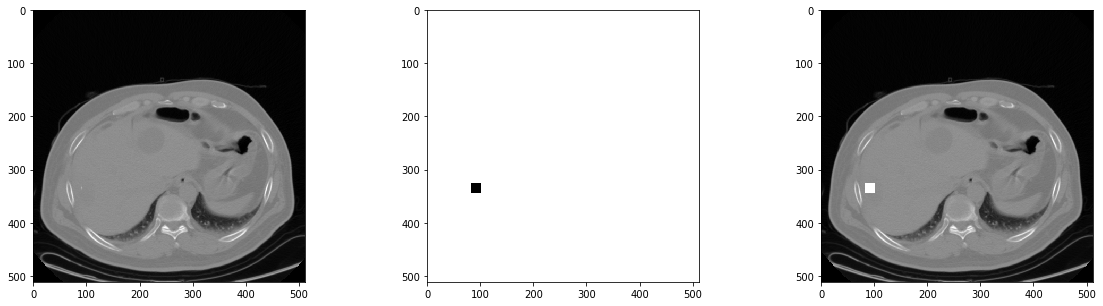

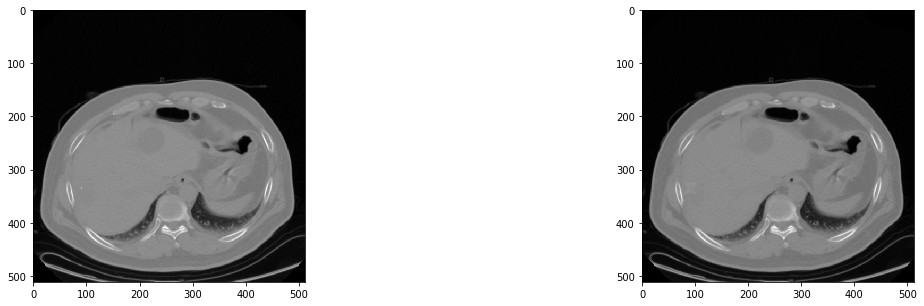

In [36]:
from skimage import io
from copy import deepcopy
import numpy as np

test_path = "/mnt/data/huojiayu/liver_image/test/ct/"
ori = io.imread(test_path + 'img/' + 'test_CT_11.png')
print(ori.shape)
mask = io.imread(test_path + 'mask/' + 'test_CT_11.png')
print(mask.shape)

if mask.shape[2] != 3:
    mask = mask[:, :, 0:3]
print(mask.shape)
# print(np.max(mask))
mask = mask / 255.
mask = 1 - mask
ori = ori / 255.

masked = deepcopy(ori)
masked[mask==0] = 1
print(masked.shape)

_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(ori)
axes[1].imshow(mask * 1.)
axes[2].imshow(masked)
plt.show()

ori = np.expand_dims(ori, axis=0)
mask = np.expand_dims(mask, axis=0)
masked = np.expand_dims(masked, axis=0)

model = PConvUnet(weight_filepath='data/logs_ct/')
model.load("data/logs_ct/62_weights_2018-11-26-16-29-07.h5")
pred_img = model.predict([masked, mask])

_, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].imshow(ori[0])
axes[1].imshow(pred_img[0] * 1.)
plt.show()